This notebook demonstrates some compiler features that were introduced in [1]. This includes dynamical decoupling, mapping via binary integer programming, and pulse-efficient SU(4) decomposition. These techniques are applicable to improving the fidelity of any circuit. Here we demonstrate their utility in Quantum Volume calculations on an IBM superconducting device. 

A custom pass manger has been built for this purpose, to invoke these passes. You can view the code in `qv_utils.py`.

Essential to this demonstration is faster CNOT gates and improved readout, as also detailed in the paper.

[1] Jurcevic, Petar, Ali Javadi-Abhari, Lev S. Bishop, Isaac Lauer, Daniela F. Bogorin, Markus Brink, Lauren Capelluto et al. "Demonstration of quantum volume 64 on a superconducting quantum computing system." Quantum Science and Technology 6, no. 2 (2021): 025020.

### I. Identify the device and region on which to measure volume

<div>
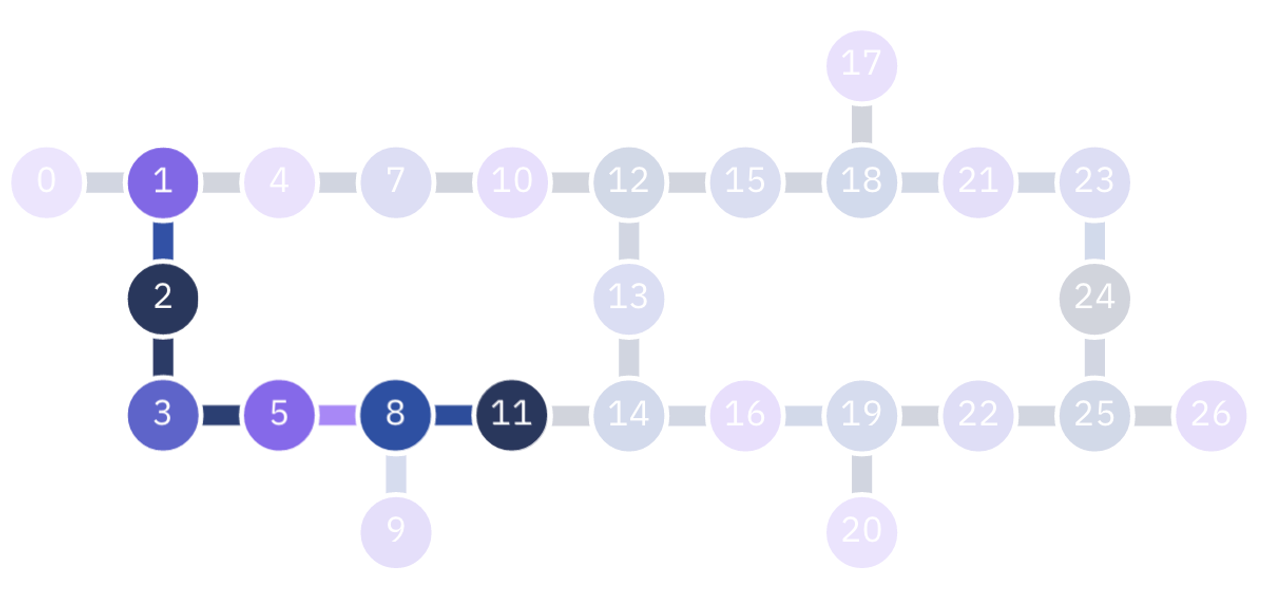
</div>

In [1]:
# choose a provider and backend you have access to

from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.providers()[5]
backend = provider.backend.ibm_hanoi

In [2]:
from qiskit.transpiler import InstructionDurations, CouplingMap

qubit_subset = [1, 2, 3, 5, 8, 11]

coupling_map = CouplingMap(backend.configuration().coupling_map)
basis_gates = backend.configuration().basis_gates
dt = backend.configuration().dt

instruction_durations = InstructionDurations.from_backend(backend)

### II. Build a custom passmanager that will do the desired circuit mapping and optimizations

In [3]:
from qv_tools import qv_passmanager
pm = qv_passmanager(basis_gates=basis_gates,
                    coupling_map=coupling_map,
                    qubit_subset=qubit_subset,
                    backend_props=backend.properties(),
                    instruction_durations=instruction_durations,
                    synthesis_fidelity=.99,
                    pulse_optimize=True)

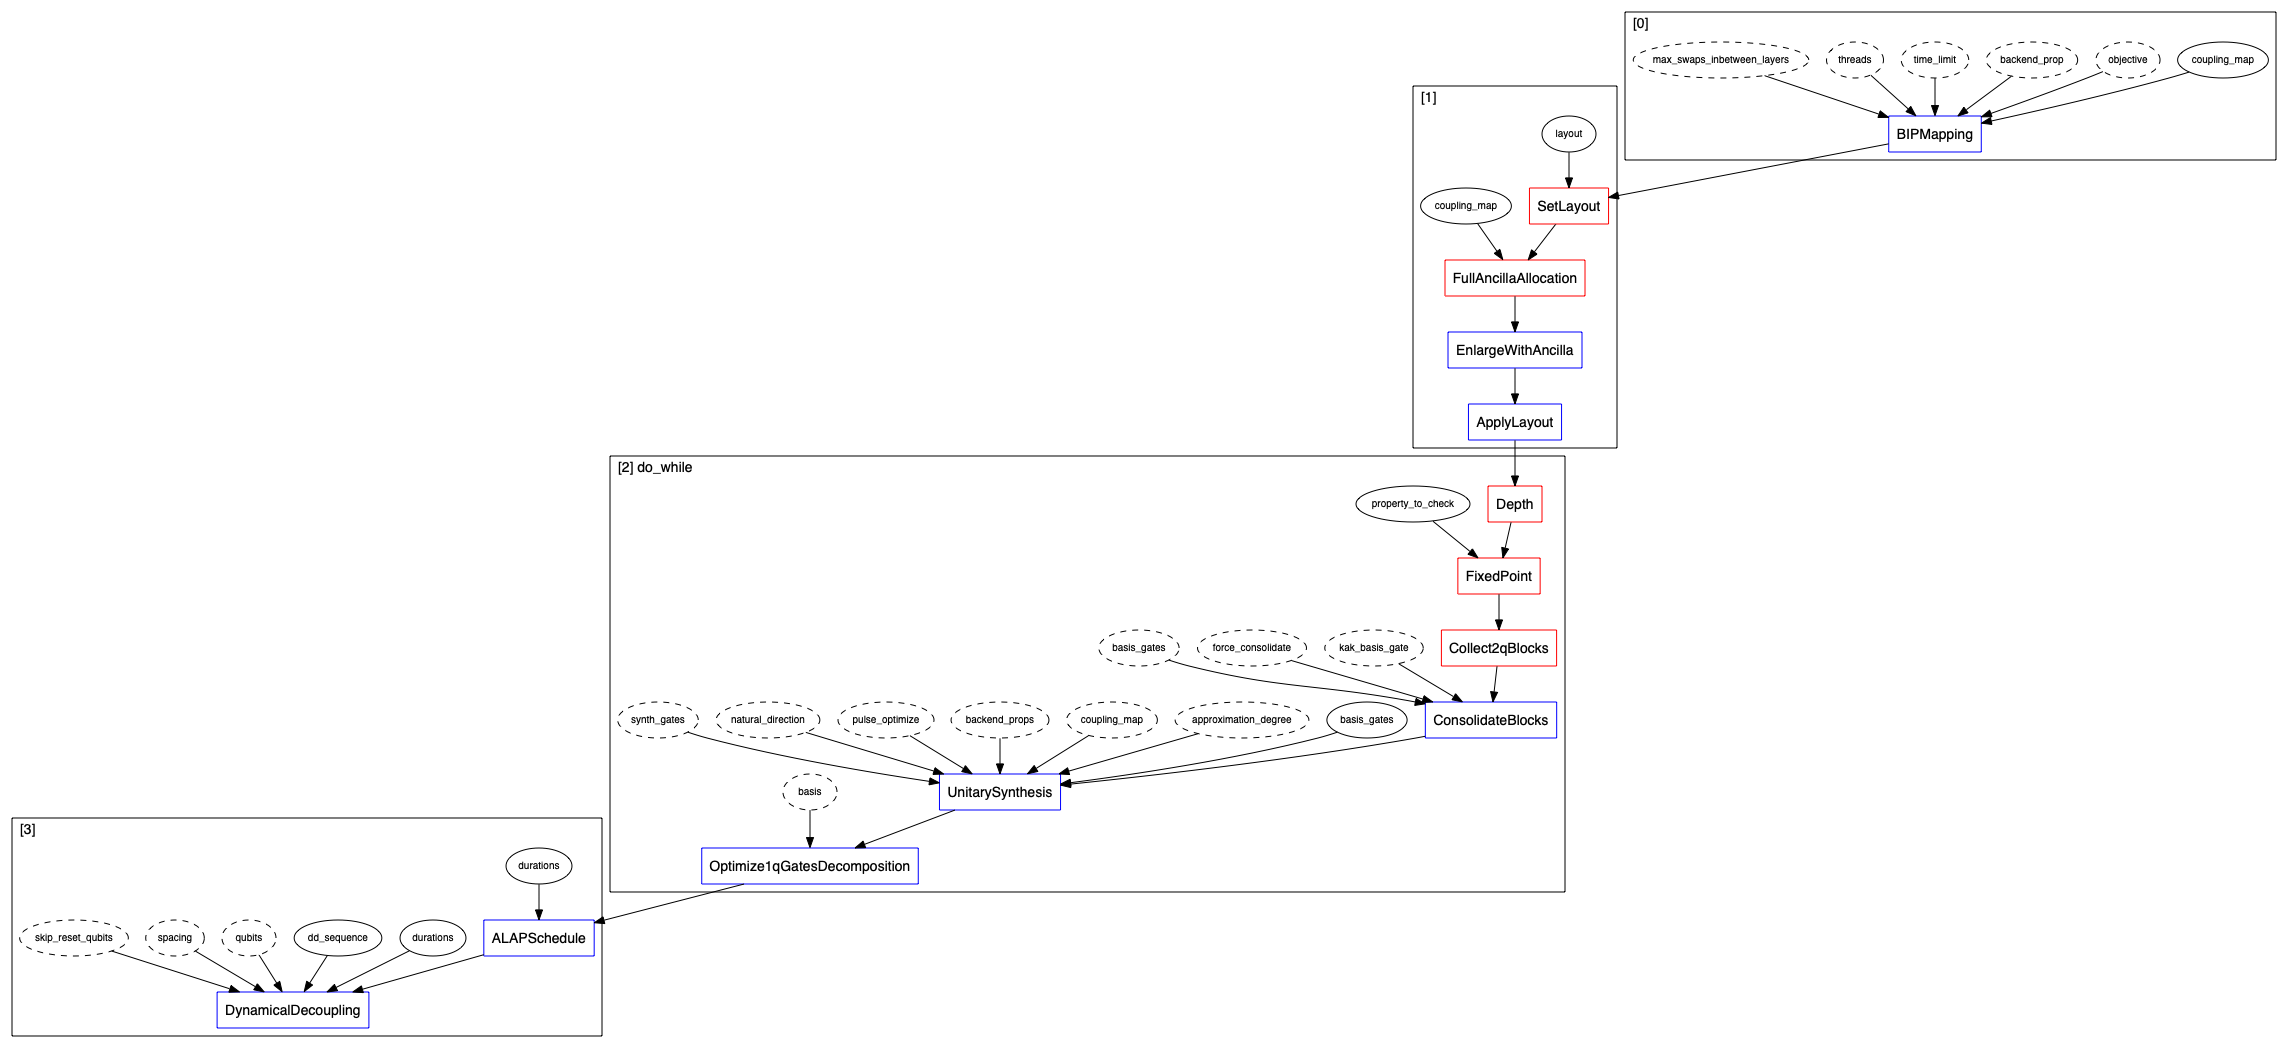

In [4]:
# optional: visualize the passmanager to see the passes invoked
pm.draw()

### III. Demonstrate compilation on a single model circuit

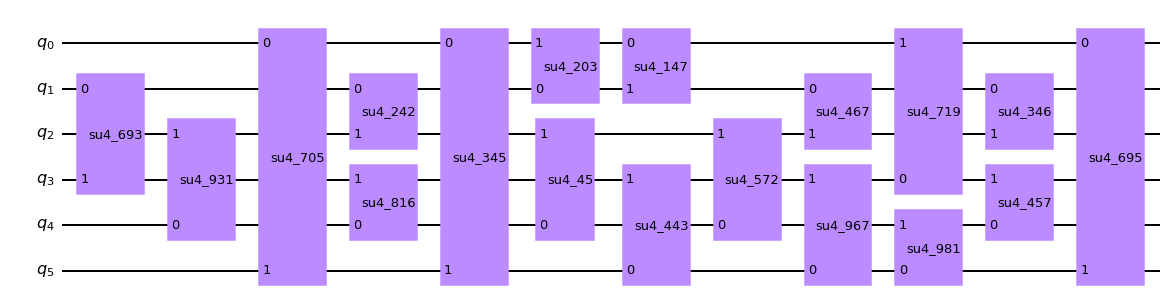

In [5]:
from qiskit.circuit.library import QuantumVolume
num_qubits = 6
model_circuit = QuantumVolume(num_qubits=num_qubits, seed=15).decompose()
model_circuit.draw('mpl', fold=-1)

In [6]:
model_circuit_measured = model_circuit.measure_all(inplace=False)
model_circuit_compiled = pm.run(model_circuit_measured)
print(f"num cx: {model_circuit_compiled.count_ops().get('cx', 0)}")
print(f"num sx: {model_circuit_compiled.count_ops().get('sx', 0)}")
print(f"num x: {model_circuit_compiled.count_ops().get('x', 0)}")
print(f"depth: {model_circuit_compiled.depth()}")
print(f"duration: {model_circuit_compiled.duration * dt * 1e6} us")

num cx: 51
num sx: 126
num x: 32
depth: 129
duration: 9.194666666666667 us


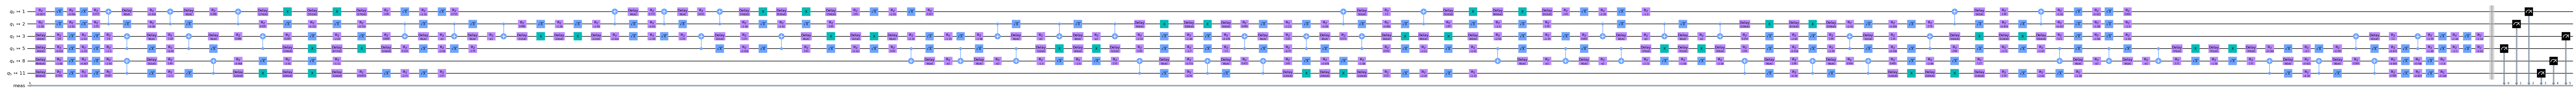

In [7]:
# optional: visualize the compiled circuit
model_circuit_compiled.draw('mpl', fold=-1, idle_wires=False)

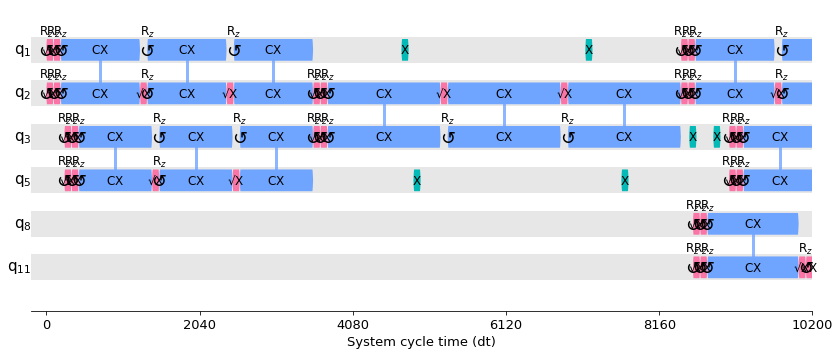

In [8]:
# optional: visualize the first 10,000 dt's of events on a timeline
from qiskit.visualization import timeline_drawer
timeline_drawer(model_circuit_compiled, time_range=(0, 10000), show_idle=False)

### IV. Compile 500 model circuits and plot distribution of resources

In [9]:
from tqdm import tqdm

model_circuits = [QuantumVolume(num_qubits, seed=i).decompose() for i in range(500)]
model_circuits_measured = [circuit.measure_all(inplace=False) for circuit in model_circuits]

model_circuits_compiled = []
for circuit in tqdm(model_circuits_measured):
    model_circuits_compiled.append(pm.run(circuit))

100%|██████████| 500/500 [59:21<00:00,  7.12s/it]  


array([<AxesSubplot:title={'center':'cx\nmean: 59.6    median: 61.0\nmin: 32     max: 78'}>,
       <AxesSubplot:title={'center':'sx\nmean: 146.8    median: 150.0\nmin: 84     max: 180'}>,
       <AxesSubplot:title={'center':'duration\nmean: 10045.1    median: 10509.5\nmin: 6705     max: 11456'}>],
      dtype=object)

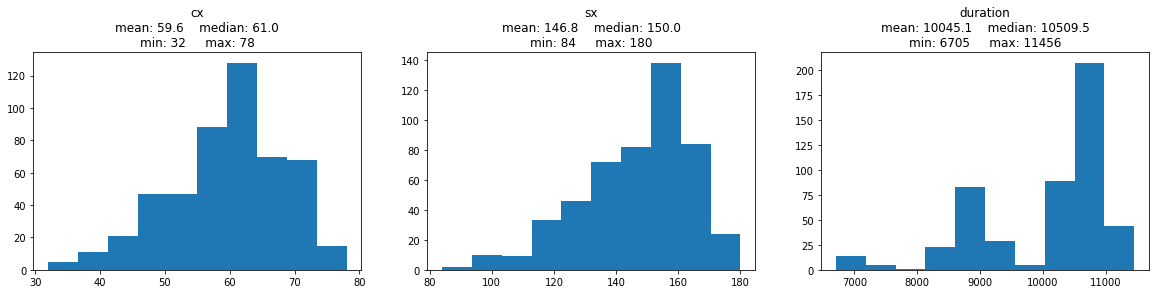

In [10]:
from qv_tools import plot_resources
plot_resources(model_circuits_compiled, dt)

### V. Run experiments and compute HOPs

In [11]:
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel
fake_backend = AerSimulator()

In [12]:
shots = 2000
job_exp = backend.run(model_circuits_compiled, shots=shots, rep_delay=0.0005)
job_sim = fake_backend.run(model_circuits_compiled, shots=shots)

In [ ]:
# optional: inquire about job status
print('status: ', job_exp.status())
print('queue position: ', job_exp.queue_position())
print('job id: ', job_exp.job_id())

In [13]:
from qv_tools import get_ideal_probabilities, get_heavy_strings, hop

hops_exp = []
hops_sim = []

for model_circuit in model_circuits:
    ideal_probs = get_ideal_probabilities(model_circuit)
    median, heavy_strings = get_heavy_strings(ideal_probs)

    counts_exp = job_exp.result().get_counts(model_circuit)
    counts_sim = job_sim.result().get_counts(model_circuit)

    hops_exp.append(hop(counts_exp, ideal_probs))
    hops_sim.append(hop(counts_sim, ideal_probs))

<AxesSubplot:xlabel='Number of Trials', ylabel='Heavy Output Probability'>

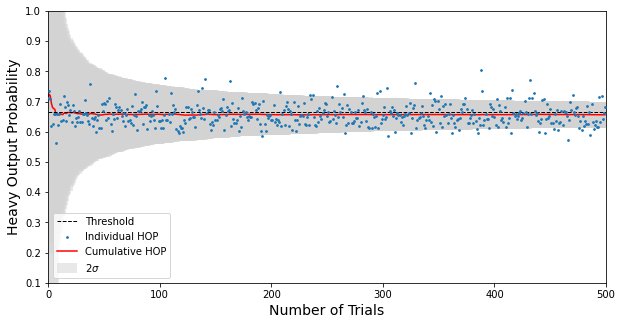

In [14]:
from qv_tools import plot_hop_accumulative
plot_hop_accumulative(hops_exp)

This notebook has been written in a self-contained way, in order to demonstrate the capabilities of the compiler and the faster gates. The `qiskit-experiments` framework includes more bells and whistles for running quantum volume experiments, as well as other experiments.

In [15]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright